# Parallelism Demo

Consider $f$ where

$$f(t) = \sum_{k\in\mathbb{N}}^{\infty}(-1)^k\dfrac{\sin[(2k+1) x]}{(2k+1)^2}$$


In [1]:
import hellaPy
from plt_style import *
import numpy as np
import pylab as plt
import scipy as sp
%matplotlib inline

In [2]:
!lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                40
On-line CPU(s) list:   0-39
Thread(s) per core:    1
Core(s) per socket:    20
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 85
Model name:            Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz
Stepping:              4
CPU MHz:               3135.498
CPU max MHz:           3700.0000
CPU min MHz:           1000.0000
BogoMIPS:              4800.00
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              1024K
L3 cache:              28160K
NUMA node0 CPU(s):     0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38
NUMA node1 CPU(s):     1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm

In [3]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           376G         13G        283G        4.1G         78G        357G
Swap:           63G         11M         63G


In [4]:
N = 10**7
t = np.linspace(0,10*np.pi,N)[:-1]
f = np.array([ (-1)**k*np.sin(ell*t)/ell**2 for k,ell in enumerate(2*np.arange(31)+1) ]).sum(axis=0)

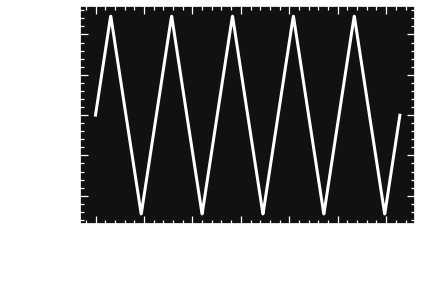

In [5]:
skip  = 1000
ts,fs= [ u[::skip] for u in [t,f] ]
plt.plot(ts,fs,'w-',lw=3)
_=plt.xticks(fontsize=20)
_=plt.yticks(fontsize=20)
_=plt.xlabel(r'$t$',fontsize=20,color='w')
_=plt.ylabel(r'$f(t)$',fontsize=20,color='w')

In [6]:
%%time
hellaPy.mkl_set_num_threads(1)
q = abs(np.fft.fft(f)[:len(t)//2])

MKL THREADS SET: 1
CPU times: user 5.57 s, sys: 590 ms, total: 6.16 s
Wall time: 6.17 s


In [7]:
%%time
hellaPy.mkl_set_num_threads(2)
q = abs(np.fft.fft(f)[:len(t)//2])

MKL THREADS SET: 2
CPU times: user 4.89 s, sys: 173 ms, total: 5.06 s
Wall time: 5.58 s


In [8]:
%%time
hellaPy.mkl_set_num_threads(4)
q = abs(np.fft.fft(f)[:len(t)//2])

MKL THREADS SET: 4
CPU times: user 2.23 s, sys: 138 ms, total: 2.37 s
Wall time: 2.43 s


In [157]:
%%time
hellaPy.mkl_set_num_threads(8)
q = abs(np.fft.fft(f)[:len(t)//2])

MKL THREADS SET: 8
CPU times: user 23.9 ms, sys: 2.73 ms, total: 26.6 ms
Wall time: 23.7 ms


In [7]:
%%time
hellaPy.mkl_set_num_threads(40)
q = abs(np.fft.fft(f)[:len(t)//2])

MKL THREADS SET: 40
CPU times: user 2.68 s, sys: 391 ms, total: 3.07 s
Wall time: 3.07 s


In [8]:
!uptime

 14:54:49 up 174 days,  5:55,  3 users,  load average: 20.06, 19.21, 19.03


In [9]:
tau = 10*np.pi
om0 = 2*np.pi/tau
om  = om0*np.arange(len(q))
p   = q/q.max()
k   = np.linspace(1,11,1001)

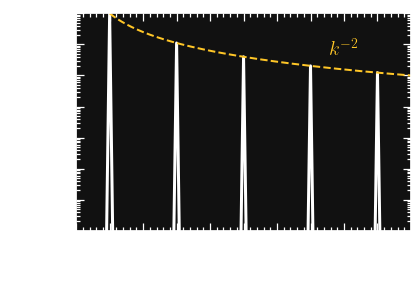

In [10]:
plt.semilogy(om,p,'w-',lw=3)
plt.semilogy(k,1/k**2,'--',c=gld,lw=2)
plt.annotate(r'$k^{-2}$',(8,5e-2),fontsize=20,color=gld,ha='center')
_=plt.xlim(0,10)
_=plt.ylim(1e-7,1)
_=plt.xticks(np.arange(10),fontsize=20)
_=plt.yticks(fontsize=20)
_=plt.xlabel(r'$\omega$',fontsize=20,color='w')
_=plt.ylabel(r'$PSD$',fontsize=20,color='w')

## Einsum On the CPU

Consider 

$$U(x,y,z) = \sum_{\ell\in\mathbb{N}\,odd}^{\infty}\dfrac{\cos(\ell x)\sin(\ell z)}{\ell^3}$$

for $(x,y,z)\in[0,\pi]^3$. Then, in the $xz$-plane, $\partial U/\partial x$ is the cartesian product of two orthogonal triangle waves.

In [12]:
import cheb

In [13]:
N = 256
Do,xo = cheb.cheb(N)
D,x = Do*2/np.pi,(xo+1)*np.pi/2
sanity = np.isclose( (D@x).sum()/(N+1),1)
print(f"Sanity: {sanity.__repr__():s}")

Sanity: True


In [14]:
X,Y,Z = np.meshgrid(x,x,x,indexing='ij')
U = np.array([ np.cos(ell*X)*np.sin(ell*Z)/ell**3 for ell in 2*np.arange(31)+1 ]).sum(axis=0)

In [15]:
hellaPy.mkl_set_num_threads(40)

MKL THREADS SET: 40


In [16]:
%%time
dUdx = np.einsum('ij,jkl->ikl',D,U)

CPU times: user 4.1 s, sys: 29 ms, total: 4.13 s
Wall time: 4.59 s


In [17]:
dUdx_iter = 0*dUdx

In [18]:
%%time
for k in range(U.shape[-1]):
    dUdx_iter[:,:,k] = D @ U[:,:,k]

CPU times: user 23 s, sys: 3.97 s, total: 26.9 s
Wall time: 1.43 s


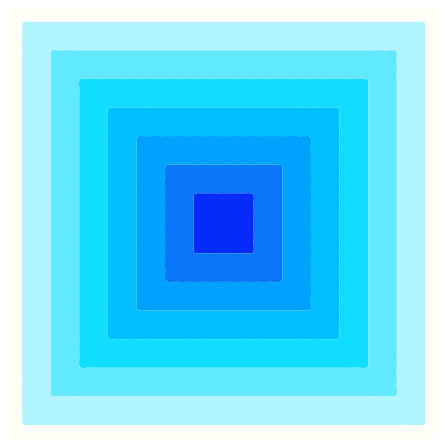

In [19]:
f,a = hellaPy.no_ax_fax()
L   = np.abs(dUdx).max() * np.linspace(-1,1,16)
hellaPy.mycontourf(X[:,128,:],Z[:,128,:],dUdx[:,128,:],L,cmap=hellaPy.mycm15)